# 假设

全眼的像差，是最终对视网膜产生影响的原因。那么使用佩戴OK镜之前、或者佩戴短期后的像差数据，是否可能预测出远期的眼轴长或者是屈光状态呢？

## 已知的缺陷

全眼像差受到多方面的影响：

* 瞳孔大小；
* 调节状态；
* 测量时间，OK镜佩戴后，白天的角膜形态是否会逐渐变化，导致像差随着时间改变。



# 数据

来自于[Predictive factors associated with axial length growth and myopia progression in orthokeratology ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6561598/ )

该文献带有excel数据，共有7个sheet，分别是：

* age, sex, visual acuity：年龄，性别，视力，其中视力用LogMAR，包含了未矫正和最佳矫正视力。
* AXL：眼轴长，用IOL master测量了中央，鼻侧30度，颞侧30度
  >AXL measurement with IOLMaster (Carl Zeiss, Jena, Germany) in central, N30, and T30 gazes
* CR：散瞳验光，用WAM-5500测量了中央，鼻侧30度，颞侧30度
  >cycloplegic refraction; autorefraction (WAM-5500; Shigiya Machinery Works Ltd., Hiroshima, Japan) in central, 30° nasal (N30), and 30° temporal (T30) gazes under cycloplegia
* MR：
  >manifested refraction
* specular microscopy：不知为何，测量了角膜内皮细胞计数。
  >evaluation of the corneal endothelium via noncontact specular microscopy (SP-8000; Konan Medical, Nishinomiya, Japan). 
* aberrometer：像差，给了高阶的Zernike系数。
  >wavefront assessment for a 6-mm pupil using a WASCA aberrometer (Carl Zeiss, Jena, Germany) following pupil dilation using a mixture of 0.5% phenylephrine and 0.5% tropicamide (Mydrin-P; Santen Pharmaceutical, Osaka, Japan)
* pentacam：角膜地形图。
  很遗憾，这里面不是raw data，只有Pre和12mo的K1, K2
* orbscan II：角膜地形图。
  也不是角膜地形图的原始数据，但除了Kmin, Kmax,还有Central corneal thickness, 3-mm-zone irregularity, 5-mm-zone irregularity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

import os

%matplotlib inline

## 数据清洗

读取数据

In [2]:
data_file=os.path.join('data',"pone.0218140.s001.xlsx")

patient_info=pd.read_excel(data_file,sheet_name="age, sex, visual acuity")
AXL=pd.read_excel(data_file,sheet_name="AXL")
CR=pd.read_excel(data_file,sheet_name="CR ")

# 以下两个sheet中，顶部有Pre，12mo一行，
# 略去，使得每一行与其他表格中的行位置相等。
aberrometer=pd.read_excel(data_file,sheet_name="aberrometer",header=1) 
cornea=pd.read_excel(data_file,sheet_name="orbscan II",header=1) 
data_frames=[patient_info,AXL,CR,aberrometer,cornea]

并不是所有的人都测量了所有的参数，所以将Patient ID和眼别整合到一起，形成一个新的eyeID。
然后合并数据

In [3]:
def clean_data(d):
    d.fillna(method='ffill',inplace = True)
    d["eyeID"]=d["Patient"]+" "+d['OD1, OS2'].map(str)
    d.drop(["Patient",'OD1, OS2'],axis=1,inplace=True)
    d.rename(columns={'Sex (male = 1, female = 2': 'sex'},inplace=True)
    d=d.where(d.eyeID.apply(lambda x: x.startswith("#"))).dropna()
    d=d.replace('*NA', np.nan).dropna() # 删除所有的*NA数据，这句话好难找

    return d

In [4]:
# drive me crazy, I don't know why I cant use for loop
patient_info=clean_data(patient_info)
AXL=clean_data(AXL)
CR=clean_data(CR)
aberrometer=clean_data(aberrometer)
cornea=clean_data(cornea)


df = reduce(lambda left,right: pd.merge(left,right,on='eyeID'), data_frames)
df = df.replace("*NA",np.nan).dropna()


将数据分成两部分，（务必要注意是否有数据泄露）

* X：从这些数据可能推导出结果，我估计会有术前的数据，一部分术后的数据。
    * patient_info中：``` ['Age','Sex (male = 1, female = 2']```
    * AXL：```['Pre C AXL', 'Pre N AXL', 'Pre T AXL'] ```
    * CR：
      ```python
         ['Pre AR C Sph', 'Pre AR C cyl',\
          'Pre AR N Sph', 'Pre AR N cyl',\
          'Pre AR T Sph', 'Pre AR T cyl']  
       ```
    * aberrometer:
        * Pre和12mo （犹豫，不知道是否有数据泄露）
    * cornea：
        * Pre和12mo
* Y：
    * AXL：12mo的C，N，T，以及delta，其中delta 12mo C AXL是最重要的数据。

In [5]:
df_x=df[[
        # 基本信息
        'sex', 'Age',
        # 术前眼轴长
        'Pre C AXL', 'Pre N AXL', 'Pre T AXL',
        # 术前验光
        'Pre AR C Sph', 'Pre AR C cyl',
        'Pre AR N Sph', 'Pre AR N cyl',
        'Pre AR T Sph', 'Pre AR T cyl',
        # 术前像差
        'C2−2', 'C20', 'C22', 'C3−3', 'C3−1', 'C31', 
        'C33', 'C4−4', 'C4−2', 'C40', 'C42', 'C44',
        # 术后像差
        'C2−2.1','C20.1', 'C22.1', 
        'C3−3.1', 'C3−1.1', 'C31.1','C33.1', 
        'C4−4.1','C4−2.1', 'C40.1', 'C42.1', 'C44.1',
        # 术前角膜地形图
       "Sim K's astigmatism", 'Kmax',
       'Kmin', 'Central corneal thickness', '3-mm-zone irregularity',
       '5-mm-zone irregularity', 'pupil diameter', 'white-to-white',
       'anterior chamber depth', 
        # 术后角膜地形图
       "Sim K's astigmatism.1", 'Kmax.1', 'Kmin.1',
       'Central corneal thickness.1', '3-mm-zone irregularity.1',
       '5-mm-zone irregularity.1', 'pupil diameter.1', 'white-to-white.1',
       'anterior chamber depth.1', 
        ]]
df_y_candidate=df[['12mo C AXL', '12mo N AXL','12mo T AXL',
         'delta C_12mo', 'delta N_12mo','delta T_12mo',
        ]]


看看12月时，眼轴变化量的分布

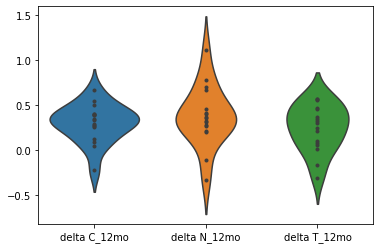

In [6]:
sns.violinplot(data=df_y_candidate[['delta C_12mo','delta N_12mo', 'delta T_12mo']], inner="points")

# 建模拟合

## 分割数据集
数据量有点少啊！只有17个可用的数据。凑合用吧。

先按照3:1的比例分割数据集，将数据集分成train和test。

In [7]:
rs=ShuffleSplit(n_splits=1, test_size=0.25)#, random_state=3)
for train_index, test_index in rs.split(df_x):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 2 16 12  1 15  9  8  6  7  3 11  5] TEST: [13  0  4 10 14]


In [8]:
target=3 # 暂时只先定一个拟合目标。
X_train=df_x.iloc[train_index,:]
y_train=df_y_candidate.iloc[train_index,target]
X_test=df_x.iloc[test_index,:]
y_test=df_y_candidate.iloc[test_index,target]

## 建立模型

## 线性拟合

In [9]:
from sklearn.linear_model import LinearRegression
model=LinearRegression().fit(X_train,y_train)

print('R-squared score (training): {:.3f}'
     .format(model.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(model.score(X_test, y_test)))

R-squared score (training): 1.000
R-squared score (test): -1.776


## 随机森林拟合

In [10]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor().fit(X_train,y_train)
print('R-squared score (training): {:.3f}'
     .format(model.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(model.score(X_test, y_test)))

R-squared score (training): 0.753
R-squared score (test): -1.857


/Users/goldengrape/anaconda3/envs/blog/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### 随机森林分类

In [11]:
from sklearn.ensemble import RandomForestClassifier

threshold=0.2 # 设定眼轴增长的分界阈值

model=RandomForestClassifier().fit(X_train,y_train>threshold)
print('R-squared score (training): {:.3f}'
     .format(model.score(X_train, y_train>threshold)))
print('R-squared score (test): {:.3f}'
     .format(model.score(X_test, y_test>threshold)))

# print(y_train>threshold)
# print(y_test>threshold)

R-squared score (training): 1.000
R-squared score (test): 0.600


/Users/goldengrape/anaconda3/envs/blog/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
predict_y_validation = model.predict(X_test)#直接给出预测结果，每个点在所有label的概率和为1，内部还是调用predict——proba()
# print(predict_y_validation)
prob_predict_y_validation = model.predict_proba(X_test)#给出带有概率值的结果，每个点所有label的概率和为1
predictions_validation = prob_predict_y_validation[:, 1]

In [13]:
print(list(y_test>threshold), predict_y_validation)

[True, False, True, True, True] [False False  True  True False]


AUC = 1.00


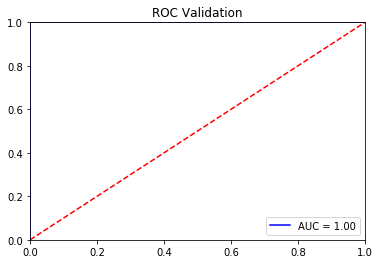

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test>threshold, predictions_validation)

roc_auc = auc(fpr, tpr)
plt.title('ROC Validation')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')

print("AUC = %0.2f" % roc_auc)

## Logistic回归

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [15]:
# from sklearn.linear_model import LogisticRegression
# model=LogisticRegression().fit(X_train,y_train)
# print('R-squared score (training): {:.3f}'
#      .format(model.score(X_train, y_train)))
# print('R-squared score (test): {:.3f}'
#      .format(model.score(X_test, y_test)))